# Land Cover Data Collection
For land cover data collection we used [GAP/LANDFIRE National Terrestrial Ecosystems 2011](https://www.sciencebase.gov/catalog/item).
> The GAP/LANDFIRE National Terrestrial Ecosystems data set includes detailed vegetation and land cover patterns for the continental United States. The data set incorporates the Ecological System classification system developed by NatureServe to represent natural and semi-natural vegetation. The 584 unique classes in the data set can be displayed at three levels of detail, from general (8 classes) to most detailed. The data set can be used to identify those places in the country with sufficient habitat to support wildlife, a key step in developing sound conservation plans. 
[**source**](https://www.usgs.gov/programs/gap-analysis-project/science/land-cover-data-overview)  
  
>> Citation: U.S. Geological Survey (USGS) Gap Analysis Project (GAP), 2016, GAP/LANDFIRE National Terrestrial Ecosystems 2011: U.S. Geological Survey data release, https://doi.org/10.5066/F7ZS2TM0.

The land cover data is a raster of GeoTIFF format, that covers the entire territory of the United States.  
![Land Cover](../../public/images/land_cover.png)  

There is also a very detailed attributes table with land cover type details:

In [62]:
land_cover_types = pd.read_excel('../../data/raw/land_cover_attributes.xlsx', skiprows = [1]) # skipping first row because it's a sum count
land_cover_types.head(5)

,Value,Count,RED,GREEN,BLUE,CL,NVC_CLASS,SC,NVC_SUBCL,FRM,NVC_FORM,DIV,NVC_DIV,MACRO_CD,NVC_MACRO,GR,NVC_GROUP,LEVEL3,ECOLSYS_LU,NVCMES
0,1,382166,0.00000,0.51765,0.49020,1,Forest & Woodland,1.A,Tropical Forest & Woodland,1.A.4,Tropical Flooded & Swamp Forest,1.A.4.Ed,Caribbean-Central American Flooded & Swamp Forest,M617,Caribbean Swamp,G002,Caribbean Lowland Swamp,9238,South Florida Bayhead Swamp,1.A.4.Ed M617G002E1
1,2,976706,0.00000,0.51765,0.49020,1,Forest & Woodland,1.A,Tropical Forest & Woodland,1.A.4,Tropical Flooded & Swamp Forest,1.A.4.Ed,Caribbean-Central American Flooded & Swamp Forest,M617,Caribbean Swamp,G002,Caribbean Lowland Swamp,9702,South Florida Cypress Dome,1.A.4.Ed M617G002E2
2,3,726902,0.00000,0.51765,0.49020,1,Forest & Woodland,1.A,Tropical Forest & Woodland,1.A.4,Tropical Flooded & Swamp Forest,1.A.4.Ed,Caribbean-Central American Flooded & Swamp Forest,M617,Caribbean Swamp,G002,Caribbean Lowland Swamp,9305,South Florida Dwarf Cypress Savanna,1.A.4.Ed M617G002E3
3,4,2875688,0.11765,0.87843,0.62353,1,Forest & Woodland,1.A,Tropical Forest & Woodland,1.A.5,Mangrove,1.A.5.Ua,Atlantic-Caribbean & East Pacific Mangrove,M005,Western Atlantic & Caribbean Mangrove,G004,Caribbean Fringe Mangrove,9236,South Florida Mangrove Swamp,1.A.5.UaM005G004E4
4,5,8327,0.16863,0.82745,0.20784,1,Forest & Woodland,1.A,Tropical Forest & Woodland,1.A.1,Tropical Dry Forest & Woodland,1.A.1.Ea,Caribbean-Mesoamerican Dry Forest,M134,Caribbean Coastal Lowland Dry Forest,G765,Caribbean Hardwood Hammock & Coastal Strand Fo...,4132,South Florida Hardwood Hammock,1.A.1.EaM134G765E5


To get the land cover categories for wildfire locations I did some reprocessing in open source GIS software [QGIS](https://www.qgis.org/en/site/). During data collection, I first converted raster resolution (pixel size) from 30 meters to 1 kilometer, so the most frequent (mode) category of original land cover was assigned to a cell in a generated lower resolution dataset.
   
Source Resolution:   
![Initial Resolution](../../public/images/land_cover_source_resolution.png)  
Processed Resolution. 
![Initial Resolution](../../public/images/land_cover_processed_resolution.png)  
  
Based on the spatial intersection of wildfire locations and land cover values, I generated a dataset with two columns: fire id and land cover category in the given location. 

In [27]:
# Some short preprocessing needed here:
# Due to QGIS ids assignment logic, where indexing starts with 1, I need to shift ids back by 1 so they match all other datasets. I'm also going to make column names more concise.
# And I have to convert land cover classes to integers because they are classes, not numeric continuous values.
import pandas as pd

landcover_points = pd.read_csv('../../data/raw/landcover_points_raw.csv')
landcover_points

,fid,Reprojected
0,1,474.0
1,2,489.0
2,3,187.0
3,4,557.0
4,5,462.0
...,...,...
21536,21537,158.0
21537,21538,461.0
21538,21539,583.0
21539,21540,360.0


In [28]:
# Fixing columns names
landcover_points.columns = ['fire_id', 'land_cover_class']

# Correcting fire id column
landcover_points['fire_id'] = landcover_points['fire_id'] - 1

# Some of the fires had incorrect InitialLatitude and InitialLongitude, so they didn't match any ;and cover categories. 
# Dropping those
landcover_points = landcover_points.dropna()

# land_cover_class: Converting floats to integers since they're classes
landcover_points['land_cover_class'] = landcover_points['land_cover_class'].astype(int)

In [65]:
# Saving processed dataset
landcover_points.to_csv('../../data/cleaned/land_cover.csv')

/var/folders/33/gxsl6tm53sl1wjmxq6vld6c80000gn/T/ipykernel_24449/4154975565.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  landcover_points.land_cover_class.value_counts()[:5].plot(kind = 'bar', color = '#D62F29');


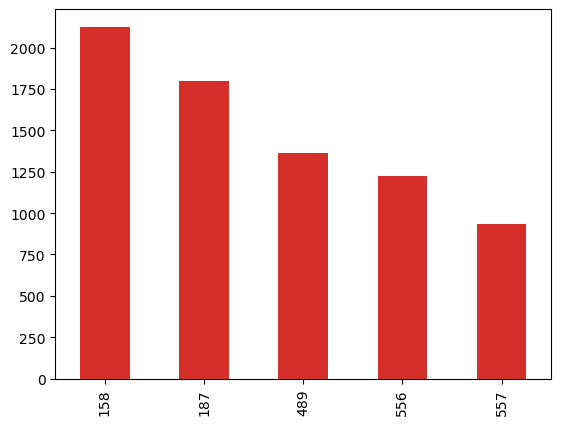

In [64]:
# Looking at most frequent categories
landcover_points.land_cover_class.value_counts()[:5].plot(kind = 'bar', color = '#D62F29');

In [54]:
# Checking which categories these are
land_cover_types[land_cover_types.Value.isin([158, 187, 489, 556, 557])]

,Value,Count,RED,GREEN,BLUE,CL,NVC_CLASS,SC,NVC_SUBCL,FRM,NVC_FORM,DIV,NVC_DIV,MACRO_CD,NVC_MACRO,GR,NVC_GROUP,LEVEL3,ECOLSYS_LU,NVCMES
158,158,54321585,0.000000,0.388240,0.07843,1,Forest & Woodland,1.B,Temperate & Boreal Forest & Woodland,1.B.2,Cool Temperate Forest & Woodland,1.B.2.Nb,Rocky Mountain Cool Temperate Forest & Woodland,M022,Southern Rocky Mountain Lower Montane Forest,G228,Southern Rocky Mountain Ponderosa Pine Forest ...,4530,Southern Rocky Mountain Ponderosa Pine Woodland,1.B.2.NbM022G228E158
187,187,107223349,0.349020,0.490200,0.08627,1,Forest & Woodland,1.B,Temperate & Boreal Forest & Woodland,1.B.2,Cool Temperate Forest & Woodland,1.B.2.Nc,Western North American Cool Temperate Woodland...,M027,Southern Rocky Mountain & Colorado Plateau Two...,G250,Colorado Plateau Pinyon - Juniper Woodland,4512,Colorado Plateau Pinyon-Juniper Woodland,1.B.2.NcM027G250E187
489,489,187305620,0.811760,0.819610,0.65882,3,Desert & Semi-Desert,3.B,Cool Semi-Desert Scrub & Grassland,3.B.1,Cool Semi-Desert Scrub & Grassland,3.B.1.Ne,Western North American Cool Semi-Desert Scrub ...,M169,Great Basin-Intermountain Tall Sagebrush Stepp...,G302,Intermountain Mesic Tall Sagebrush Steppe & Sh...,5706,Inter-Mountain Basins Big Sagebrush Shrubland,3.B.1.NeM169G302E489
556,556,1532431380,0.960784,0.960784,0.86275,7,Agricultural & Developed Vegetation,7.B,Herbaceous Agricultural Vegetation,7.B.1,Row & Close Grain Crop Cultural Formation,7.B.1,Herbaceous Agricultural Vegetation,7.B.1,Herbaceous Agricultural Vegetation,7.B.1,Row & Close Grain Crop Cultural Formation,1402,Cultivated Cropland,7.AE556
557,557,655777154,0.996080,0.996080,0.75686,7,Agricultural & Developed Vegetation,7.B,Herbaceous Agricultural Vegetation,7.B.2,Pasture & Hay Field Crop,7.B.2,Pasture & Hay Field Crop,7.B.2,Pasture & Hay Field Crop,7.B.2,Pasture & Hay Field Crop,1403,Pasture/Hay,7.AE557


Land cover dataset has 164 unique classes.